In [1]:
# Importing libraries
import healpy as hp
import matplotlib.pyplot as plt
import numpy as np
import pymaster as nmt

In [2]:
#Read the map
Planck_SMICA=hp.read_map('/home/akozameh/COM_CMB_IQU-smica_2048_R3.00_hm2.fits')

In [3]:
#Read the mask
mask=hp.read_map('/home/akozameh/cmblss/data/COM_Mask_CMB-common-Mask-Int_2048_R3.00.fits')

Since we are interested in large-angular scale, the maps were degraded at NSIDE = 64 and NSIDE=16

In [4]:
#Planck SMICA degraded map
Planck_1=hp.pixelfunc.ud_grade(Planck_SMICA, 64)       #degraded maps at NSIDE=64
Planck_2=hp.pixelfunc.ud_grade(Planck_SMICA, 16)       #degraded maps at NSIDE=16
mask_deg=hp.pixelfunc.ud_grade(mask,64)                #degraded mask at NSIDE=16

In [5]:
# Creating new mask in equatorial coordinates
NSIDE = 64
ipix=hp.nside2npix(NSIDE)
m=np.zeros(ipix) #mask


type(ipix)

int

In [6]:
# I make a list of thetas and phi 
thetas=[]
phis=[]
for j in range(0,(ipix)):
    theta,phi=(hp.pix2ang(NSIDE, j))
    thetas.append(theta)
    phis.append(phi)


In [7]:
# it makes theta and phi array by numpy array
theta_a=np.array(thetas)
phis_a=np.array(phis)

In [8]:
phis_a

array([0.78539816, 2.35619449, 3.92699082, ..., 2.35619449, 3.92699082,
       5.49778714])

In [9]:
# Converting the theta, phi in r.a and decl.
decl=np.rad2deg(0.5 * np.pi - theta_a)
ra = np.rad2deg(phis_a)

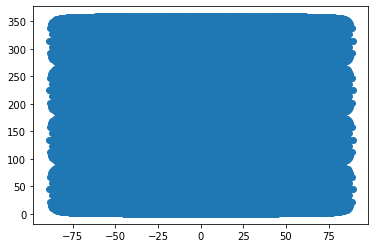

In [10]:
plt.scatter(decl,ra)

In [12]:
cond1 = decl>-70
cond2 = decl<30
mask  = cond1 & cond2

In [13]:
type(mask)

numpy.ndarray

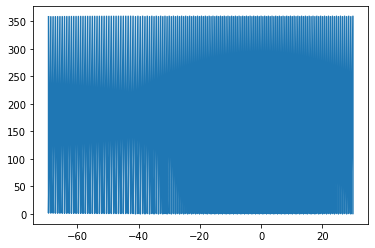

In [14]:
plt.plot(decl[mask],ra[mask])

In [15]:
# Convert the decl and r.a in theta and phi
theta = 0.5 * np.pi - np.deg2rad(decl[mask])
phi = np.deg2rad(ra[mask])


In [16]:
# It Converts theta and phi in number of pixeles
pix=hp.ang2pix(NSIDE,theta,phi)
pix

array([12160, 12161, 12162, ..., 47637, 47638, 47639])

In [17]:
m[pix]=1

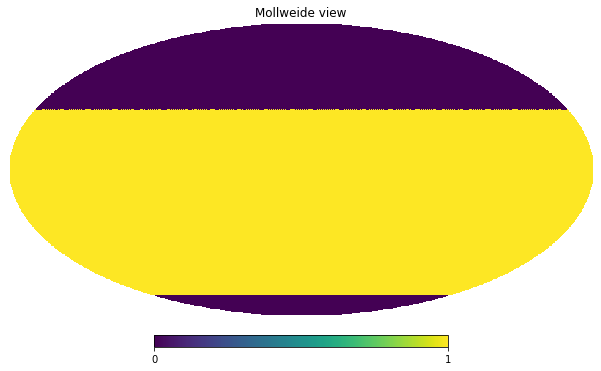

In [18]:
hp.mollview(m)

In [19]:
rot=hp.Rotator(coord=['C','G'])  # Transforms equatorial to galactic coordinates

In [20]:
# Rotate the map to galactic coordinates
m=rot.rotate_map_pixel(m) 

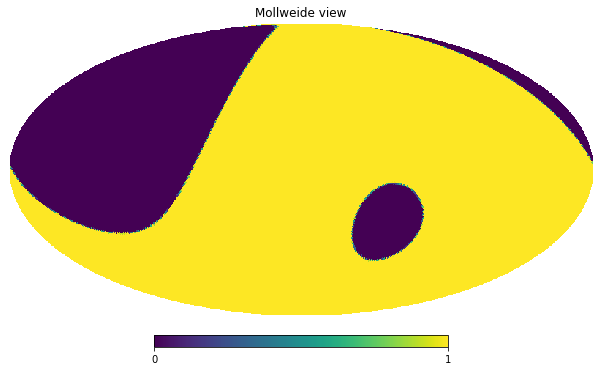

In [21]:
hp.mollview(m)

In [22]:
# Total mask
mask_total=m * mask_deg

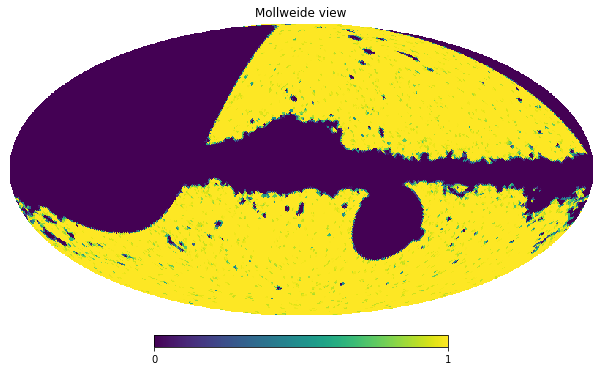

In [23]:
# Total mask is shown
hp.mollview(mask_total)

# In this part I will compute the cls and pseudo cls

In [24]:
# An NmtField object contains all the information describing the fields to correlate, 
# including their observed maps, masks and contaminant templates.
f_0=nmt.NmtField(mask_total, [Planck_1])

In [25]:
# Initialize binning scheme with 4 ells per bandpower
# Convenience constructor for HEALPix maps with linear binning.
b = nmt.NmtBin.from_nside_linear(NSIDE, 4)

In [26]:
# Compute MASTER estimator
# spin-0 x spin-0
#Computes the full MASTER estimate of the power spectrum of two fields (f1 and f2). 
cl_00 = nmt.compute_full_master(f_0, f_0, b)

In [27]:
# Shape of the pseudo Cls
cl_00.shape


(1, 47)

In [28]:
#Returns an array with the effective multipole associated to each bandpower. 
#These are computed as a weighted average of the multipoles within each bandpower.
el = b.get_effective_ells()
el.shape

(47,)

In [29]:
dl=cl_00[0]*[(1e6)**(2)]*el*(el+1)/2/np.pi

In [30]:
dl.shape

(47,)

In [31]:
# Interpolation of the pseudo Dls
from scipy.interpolate import interp1d

In [32]:
# I define the interpolation with x**3
f=interp1d(el, dl, kind='cubic') 

In [33]:
# I define my news l
lnew=np.linspace(4, 47, 47)
# oncatenate

In [34]:
#pdl is the interpolation of the pseudo Dls
pdl_int=f(lnew)

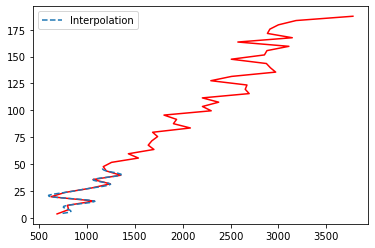

In [35]:
plt.plot(dl,el,'r')
plt.plot(pdl_int, lnew,'--', label='Interpolation')
plt.legend()

In [36]:
# Concatenate the ls
ljoin=np.concatenate((([0,0,2,3]),lnew))
# Concatenate the pseudo Dls
pDl_=np.concatenate((([0.0,0.0,203.36331868506028,918.9783866182479]),pdl_int ))

In [37]:
# pDl_ is may new array
pDl_.shape

(51,)

In [38]:
dl_1=np.ones((len(dl),4))
dl_1[:,0]=dl
dl_1.shape

(47, 4)

In [39]:
Dl=np.ones((len(pDl_),4))
Dl[:,0]=pDl_
Dl.shape

(51, 4)

In [40]:
# In this part I compute the correlation function 
# Importing libraries
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import sys, platform, os

In [41]:
camb_path = os.path.realpath(os.path.join(os.getcwd(),'..'))
sys.path.insert(0,camb_path)
import camb
from camb import model, initialpower, correlations
print('Using CAMB %s installed at %s'%(camb.__version__,os.path.dirname(camb.__file__)))

Using CAMB 1.3.5 installed at /home/akozameh/miniconda3/envs/CMB/lib/python3.10/site-packages/camb


In [42]:
corr1, xvals_1, weights = correlations.gauss_legendre_correlation(Dl)
corr2, xvals_2, weights2 = correlations.gauss_legendre_correlation(dl_1)
#xvals2=np.linspace(-1,1,2502)
r1=np.arccos(xvals_1)*180/np.pi # sampled theta values in degrees
r2=np.arccos(xvals_2)*180/np.pi

In [58]:
r1

array([177.32457883, 173.85879211, 170.37253819, 166.88166006,
       163.38902807, 159.89554763, 156.40159331, 152.90734782,
       149.41291088, 145.91834151, 142.42367691, 138.92894168,
       135.43415276, 131.93932225, 128.44445899, 124.94956963,
       121.45465932, 117.95973207, 114.46479112, 110.9698391 ,
       107.47487824, 103.97991041, 100.48493726,  96.98996025,
        93.49498074,  90.        ,  86.50501926,  83.01003975,
        79.51506274,  76.02008959,  72.52512176,  69.0301609 ,
        65.53520888,  62.04026793,  58.54534068,  55.05043037,
        51.55554101,  48.06067775,  44.56584724,  41.07105832,
        37.57632309,  34.08165849,  30.58708912,  27.09265218,
        23.59840669,  20.10445237,  16.61097193,  13.11833994,
         9.62746181,   6.14120789,   2.67542117])

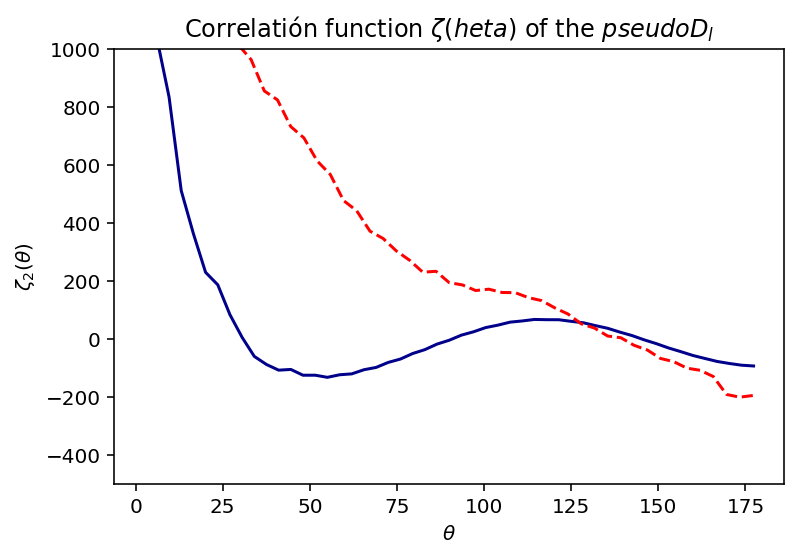

In [43]:
plt.plot(r1, corr1[:,0], color = 'darkblue')
plt.plot(r2,corr2[:,0],'--', color='red')
plt.ylabel(r'$\zeta_{2}(\theta)$')
plt.xlabel(r'$\theta$')
plt.title('Correlatión function $\zeta (\theta)$ of the $pseudo D_{l}$')
plt.ylim(-500,1000)
plt.show()

In [44]:
# In this part I create the python array to repdroduce the schi data
d=[] # I make a list
d=np.array(d)

In [45]:
print('the original array is:')
print(d)
print('------------------')

the original array is:
[]
------------------


In [59]:
# adding new colums
d_array=np.loadtxt('/home/akozameh/cmblss/data/schi.csv', delimiter=',')
d_array.shape

(39, 2)

In [64]:
# I delete the last component because is out of range
d1=np.delete(d_array,38,0)
d1.shape

(38, 2)

In [68]:
d1


array([[ 5.42600e+00,  9.84030e+02],
       [ 7.02100e+00,  9.14829e+02],
       [ 8.29800e+00,  8.34981e+02],
       [ 9.57400e+00,  7.55133e+02],
       [ 1.14890e+01,  6.06084e+02],
       [ 1.46810e+01,  4.41065e+02],
       [ 1.65960e+01,  3.66540e+02],
       [ 1.91490e+01,  2.12167e+02],
       [ 2.04260e+01,  1.37643e+02],
       [ 2.48940e+01,  2.05320e+01],
       [ 2.74470e+01, -3.27000e+01],
       [ 3.12770e+01, -6.99620e+01],
       [ 3.44680e+01, -9.12550e+01],
       [ 4.21280e+01, -9.65780e+01],
       [ 4.72340e+01, -1.12548e+02],
       [ 5.36170e+01, -1.17871e+02],
       [ 6.06380e+01, -9.12550e+01],
       [ 6.51060e+01, -6.46390e+01],
       [ 6.82980e+01, -2.73760e+01],
       [ 7.46810e+01,  1.52090e+01],
       [ 7.97870e+01,  1.52090e+01],
       [ 8.36170e+01, -7.60000e-01],
       [ 8.61700e+01, -1.14070e+01],
       [ 9.12770e+01, -2.20530e+01],
       [ 9.51060e+01, -2.73760e+01],
       [ 1.02128e+02, -7.60000e-01],
       [ 1.07234e+02,  3.11790e+01],
 

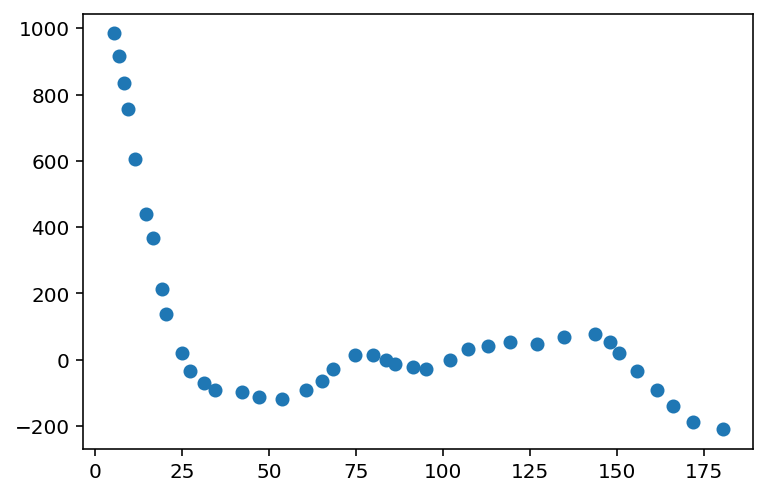

In [47]:
plt.scatter(d_array[:,0], d_array[:,1], label='schi et al. (2023)')

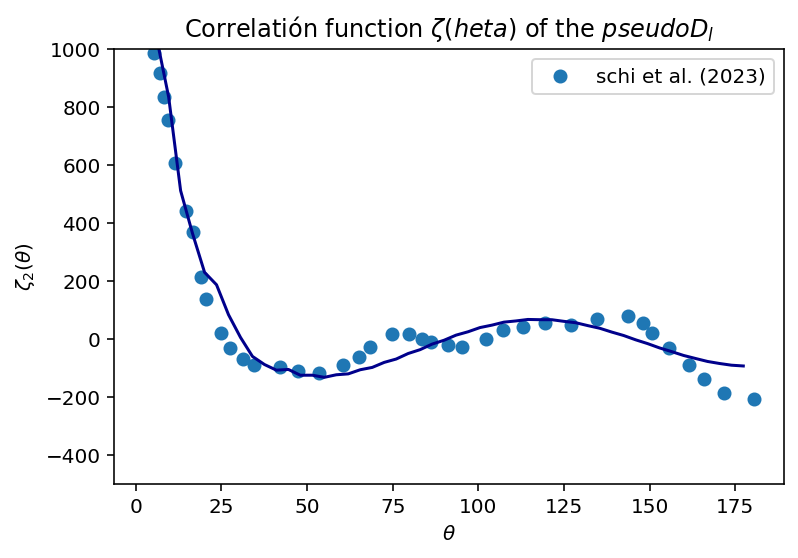

In [50]:
plt.plot(r1, corr1[:,0], color = 'darkblue')
plt.scatter(d_array[:,0], d_array[:,1], label='schi et al. (2023)')
plt.ylabel(r'$\zeta_{2}(\theta)$')
plt.xlabel(r'$\theta$')
plt.title('Correlatión function $\zeta (\theta)$ of the $pseudo D_{l}$')
plt.ylim(-500,1000)
plt.legend()
plt.show()


In [55]:
# I define a new interpolation with x**3
f1=interp1d(r1, corr1[:,0] , kind='cubic') 

In [67]:
# I define my news thetas anc c_theta
theta_1=d1
c_theta=f1(d1)

ValueError: A value in x_new is below the interpolation range.